### Edge elements on triangles
This is based on $2 \times 2$-element resonator example from "Computational Electromagnetics", 2000
but solved with code from Davidson ("Computational Electromagnetics for RF and Microwave Engineering", 2011)

In [1]:
# helper functions
using LinearAlgebra
include("whitney.jl")
include("meshing.jl")
nothing

In [2]:
function SandT(x1, y1, x2, y2, x3, y3)
    global LOCALEDGENODES

    area = .5abs(det([1. x1 y1
                      1. x2 y2
                      1. x3 y3]))
    temp = inv([x1 x2 x3
                y1 y2 y3
                1. 1. 1.])
    b = temp[:,1]
    c = temp[:,2]
    a = temp[:,3]
    ∇λ = [[b[1], c[1]],
          [b[2], c[2]],
          [b[3], c[3]]]
    φ = zeros(3, 3) # φij = ∇λi ⋅ ∇λj = (bi⋅ci + bj⋅cj)
    v = zeros(3, 3) # vij = ∇λi × ∇λj = (bi⋅cj - bj⋅ci)ẑ
    for ii = 1:3
       for jj = 1:3
           φ[ii, jj] = b[ii] * b[jj] + c[ii] * c[jj]
           v[ii, jj] = b[ii] * c[jj] - b[jj] * c[ii]
       end 
    end

    M = [2. 1. 1.
         1. 2. 1.
         1. 1. 2.] / 12.0

    # Compute S and T
    S = zeros(3, 3)
    T = zeros(3, 3)
    for ii = 1:3
       for jj = 1:3
         i1 = LOCALEDGENODES[ii,1]
         i2 = LOCALEDGENODES[ii,2]
         j1 = LOCALEDGENODES[jj,1]
         j2 = LOCALEDGENODES[jj,2]
         S[ii,jj] = 4area*v[i1, i2] * v[j1, j2]
         T[ii,jj] = area*(φ[i2, j2] * M[i1, j1] +
                        - φ[i2, j1] * M[i1, j2] +
                        - φ[i1, j2] * M[i2, j1] +
                        + φ[i1, j1] * M[i2, j2])
       end 
    end
    
    return S, T
end

SandT (generic function with 1 method)

In [3]:
function simplex2D(elem_num, xp, yp)
    global ELEMENTS
    global NODE_COORD 

    trinodes = ELEMENTS[elem_num, :]; 
    x1 = NODE_COORD[trinodes[1],1];
    y1 = NODE_COORD[trinodes[1],2];
    x2 = NODE_COORD[trinodes[2],1];
    y2 = NODE_COORD[trinodes[2],2];
    x3 = NODE_COORD[trinodes[3],1];
    y3 = NODE_COORD[trinodes[3],2];

    σ0 = det([1. x1 y1; 1. x2 y2; 1. x3 y3]);
    σ1 = det([1. xp yp; 1. x2 y2; 1. x3 y3]);
    σ2 = det([1. x1 y1; 1. xp yp; 1. x3 y3]);
    σ3 = det([1. x1 y1; 1. x2 y2; 1. xp yp]);
    λ  = [σ1/σ0, σ2/σ0, σ3/σ0]
    return λ
end

simplex2D (generic function with 1 method)

In [4]:
# Parameters
ε0 = 1.
μ0 = 1.
εr = 1.
μr = 1.
σ  = 0.
ε  = ε0 * εr
μ  = μ0 * μr

a, b = 1.3, 0.9
n, m = 13, 9
nothing

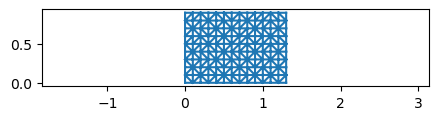

In [5]:
using PyPlot

LOCALEDGENODES = [1 2; 1 3; 2 3]
trimesh(a, b, n, m)
triedgemake()

figure(figsize=(5,1))
triplot(NODE_COORD[:,1], NODE_COORD[:,2], triangles=(ELEMENTS .- 1)); # subtract 1 as we go into Python-world
axis("equal");

In [6]:
NODE_COORD[:,1]

140-element Vector{Float64}:
 0.0
 0.1
 0.2
 0.30000000000000004
 0.4
 0.5
 0.6000000000000001
 0.7000000000000001
 0.8
 0.9
 1.0
 1.1
 1.2000000000000002
 ⋮
 0.2
 0.30000000000000004
 0.4
 0.5
 0.6000000000000001
 0.7000000000000001
 0.8
 0.9
 1.0
 1.1
 1.2000000000000002
 1.3

In [7]:
NODE_COORD[:,2]

140-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.9
 0.9
 0.9
 0.9
 0.9
 0.9
 0.9
 0.9
 0.9
 0.9
 0.9
 0.9

In [8]:
triangles=(ELEMENTS .- 1)

234×3 Matrix{Int64}:
   0    1   14
   1    2   15
   2    3   16
   3    4   17
   4    5   18
   5    6   19
   6    7   20
   7    8   21
   8    9   22
   9   10   23
  10   11   24
  11   12   25
  12   13   26
   ⋮       
 114  127  128
 115  128  129
 116  129  130
 117  130  131
 118  131  132
 119  132  133
 120  133  134
 121  134  135
 122  135  136
 123  136  137
 124  137  138
 125  138  139

In [9]:
DOF_NONE = 0
DOF_PEC  = 1

function dof_type(a, b)
    global NUM_EDGES
    global EDGES
    global NODE_COORD
    dof_flag = zeros(Int64, NUM_EDGES)
    
    for i_edge = 1:NUM_EDGES
       node1 = EDGES[i_edge, 1]
       node2 = EDGES[i_edge, 2]
       if NODE_COORD[node1, 2] ≈ 0. && NODE_COORD[node2, 2] ≈ 0. # ie y=0
           dof_flag[i_edge] = DOF_PEC
       end
       if NODE_COORD[node1, 2] ≈ b  && NODE_COORD[node2, 2] ≈ b  # ie y=b
           dof_flag[i_edge] = DOF_PEC
       end
       if NODE_COORD[node1, 1] ≈ 0. && NODE_COORD[node2, 1] ≈ 0. # ie x=0
           dof_flag[i_edge] = DOF_PEC
       end
       if NODE_COORD[node1, 1] ≈ a  && NODE_COORD[node2, 1] ≈ a  # ie x=a
           dof_flag[i_edge] = DOF_PEC
       end
    end
    return dof_flag
end

dof_type (generic function with 1 method)

In [10]:
function dof_renumber!(dof, Γ)
    global NUM_EDGES
    global NUM_DOFS
    last = 0
    for i_edge = 1:NUM_EDGES
       if Γ[i_edge] == 0
         dof[i_edge] = last + 1
         last += 1
       else
         dof[i_edge] = 0
       end
    end
    NUM_DOFS = last
    return dof
end

dof_renumber! (generic function with 1 method)

In [11]:
dof = collect(1:NUM_EDGES)

Γ = dof_type(a, b)
dof_renumber!(dof, Γ);

In [12]:
# ASSUMPTION: Waveguide is homogenous
# Assemble stiffness and mass matrices
S = zeros(NUM_DOFS, NUM_DOFS) # 1/μr ∫( ∇Ni × ∇Nj )dΩ
T = zeros(NUM_DOFS, NUM_DOFS) # μ0 ε ∫( ∇Ni ⋅ ∇Nj )dΩ

for ielem = 1:NUM_ELEMS # Assemble by elements
  trinodes = ELEMENTS[ielem, :]
  Se, Te = SandT(NODE_COORD[trinodes[1],1], NODE_COORD[trinodes[1],2],
                 NODE_COORD[trinodes[2],1], NODE_COORD[trinodes[2],2],
                 NODE_COORD[trinodes[3],1], NODE_COORD[trinodes[3],2])
  
  for jedge = 1:3
    jj = dof[ELEMENT_EDGES[ielem, jedge]]
    if jj == 0 continue end
    for kedge = 1:3
      kk = dof[ELEMENT_EDGES[ielem, kedge]]
      if kk == 0 continue end
      S[jj, kk] = S[jj, kk] + (1/μr) * Se[jedge, kedge]
      T[jj, kk] = T[jj, kk] + (μ0*ε) * Te[jedge, kedge]
    end
  end
end

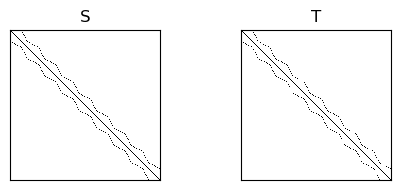

In [13]:
figure(figsize=(5, 2))
subplot(1, 2, 1); spy(S); title("S"); xticks([]); yticks([]);
subplot(1, 2, 2); spy(T); title("T"); xticks([]); yticks([]);
tight_layout()

In [14]:
using LinearAlgebra

k², e = eigen(S, T)

speed_of_light = 299_792_458.
for n in 1:length(k²)
    wavenumber_squared = k²[n]
    if imag(wavenumber_squared) ≈ 0.0
        if real(wavenumber_squared) > 0.0
            frequency = sqrt(abs(wavenumber_squared)) / 2π * speed_of_light
            if 114e6 < frequency < 116e6
                println(n, ". ", 1e-6frequency, "MHz")
            end
        end
    end
end

97. 115.21108990700745MHz


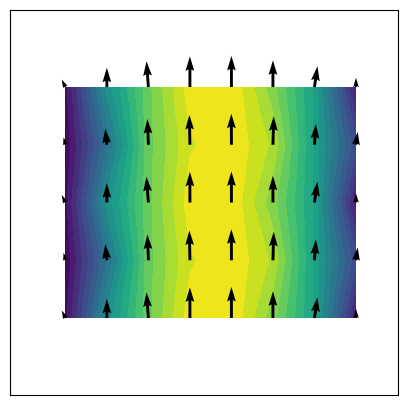

In [15]:
n = 97
x = 0.1:0.15:1.2
y = 0.1:0.15:0.8
E = evaluate(WhitneyTriangleElement(), e[:, n], dof, x, y)
normE  = @. sqrt(E[:, :, 1]^2 + E[:, :, 2]^2)
xx = [x for _ in y, x in x]
yy = [y for y in y, _ in x]

figure(figsize=(5, 5))
contourf(xx', yy', normE, levels=20)
quiver(xx', yy', E[:, :, 1], E[:, :, 2])
xlim([-0.1, +1.3])
ylim([-0.1, +0.9])
xticks([]); yticks([]);